## db 접근하기

In [2]:
import psycopg2, pprint
connection = psycopg2.connect(database="pythonspatial", user="dajomi", password="dajomi")
cursor = connection.cursor()

## point 테이블 만들기

In [ ]:
cursor.execute("CREATE TABLE points (id SERIAL PRIMARY KEY, name VARCHAR(255), location GEOMETRY)")
connection.commit()

## 데이터 넣기(ST_GeomFromText로 wkt 형식으로 넣기)

In [3]:
cursor.execute("INSERT INTO points (name, location) VALUES ('p1', ST_GeomFromText('POINT(100 40)'))")
cursor.execute("INSERT INTO points (name, location) VALUES ('p1', ST_GeomFromText('POINT(100 30)'))")
cursor.execute("INSERT INTO points (name, location) VALUES ('p1', ST_GeomFromText('POINT(100 20)'))")
cursor.execute("INSERT INTO points (name, location) VALUES ('p1', ST_GeomFromText('POINT(120 45)'))")
cursor.execute("INSERT INTO points (name, location) VALUES ('p1', ST_GeomFromText('POINT(140 35)'))")
cursor.execute("INSERT INTO points (name, location) VALUES ('p1', ST_GeomFromText('POINT(110 45)'))")
connection.commit()

## 데이터 넣기(shapely를 이용하여 wkt 형식으로 넣기)

In [6]:
from shapely.geometry import Point, MultiPoint
p = [Point(100,200), Point(100,100)]
for pp in p:
    s = ("INSERT INTO points (name, location) VALUES ('p1',ST_GeomFromText('{}'))").format(pp.wkt)
    cursor.execute(s)
connection.commit() 

cursor.execute("SELECT * from points") 
cursor.fetchall() 

[(1, 'p1', '010100000000000000000059400000000000004440'),
 (2, 'p1', '010100000000000000000059400000000000003E40'),
 (3, 'p1', '010100000000000000000059400000000000003440'),
 (4, 'p1', '01010000000000000000005E400000000000804640'),
 (5, 'p1', '010100000000000000008061400000000000804140'),
 (6, 'p1', '01010000000000000000805B400000000000804640'),
 (7, 'p1', '010100000000000000000059400000000000006940'),
 (8, 'p1', '010100000000000000000059400000000000005940')]

In [9]:
from shapely.geometry import Point, MultiPoint
p = [Point(130, 200), Point(100,130)]
for pp in p:
    s = ("INSERT INTO points (name, location) VALUES ('p2', ST_GeomFromText('{}'))").format(pp.wkt) #format(pp.wkt) : WKT를 {} 플레이스 홀더에 전달
    cursor.execute(s)
connection.commit()

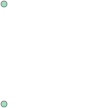

In [7]:
MultiPoint(p)

## 테이블 조회(WKB 형태로 출력)

In [8]:
cursor.execute("SELECT * from points")
data = cursor.fetchall()
data

[(1, 'p1', '010100000000000000000059400000000000004440'),
 (2, 'p1', '010100000000000000000059400000000000003E40'),
 (3, 'p1', '010100000000000000000059400000000000003440'),
 (4, 'p1', '01010000000000000000005E400000000000804640'),
 (5, 'p1', '010100000000000000008061400000000000804140'),
 (6, 'p1', '01010000000000000000805B400000000000804640'),
 (7, 'p1', '010100000000000000000059400000000000006940'),
 (8, 'p1', '010100000000000000000059400000000000005940')]

## WKB -> Point -> WKT 변환

In [9]:
from shapely.wkb import loads
aPoint = loads(data[0][2], hex = True)
aPoint.wkt

'POINT (100 40)'

## 좌표계 설정/변경
- updateGeometrySRID : geometry에 좌표계 설정함
- Find_SRID : geometry가 어떤 좌표계인지 보여줌
- ST_Transform : 좌표계를 변경함

In [2]:
cursor.execute("SELECT UpdateGeometrySRID('points', 'location', 4326)")
cursor.execute("SELECT Find_SRID('public', 'points', 'location')")
cursor.fetchall()

cursor.execute("SELECT name, ST_AsTexT(ST_Transform(location, 3857)) from points")

InternalError_: 오류:  transform: latitude or longitude exceeded limits (-14)


## 버퍼

In [5]:
cursor.execute("SELECT ST_AsTexT(ST_Buffer(a.location,25.00, 'quad_segs=2')) from points a WHERE a.name='p1'")
data = cursor.fetchall()
data

# arc name 필드가 p1과 동일한 테이블의 레코드를 선택하고, location 주변에 반지름 25의 버퍼를 선택한다. 그 결과는 폴리곤이 된다

[('POLYGON((125 40,117.6776695296637 22.32233047033633,100.00000000000004 15,82.32233047033635 22.322330470336272,75 39.99999999999992,82.32233047033624 57.67766952966362,99.99999999999989 65,117.67766952966359 57.67766952966379,125 40))',),
 ('POLYGON((125 30,117.6776695296637 12.322330470336329,100.00000000000004 5,82.32233047033635 12.322330470336272,75 29.99999999999992,82.32233047033624 47.67766952966362,99.99999999999989 55,117.67766952966359 47.67766952966379,125 30))',),
 ('POLYGON((125 20,117.6776695296637 2.322330470336329,100.00000000000004 -5,82.32233047033635 2.322330470336272,75 19.99999999999992,82.32233047033624 37.67766952966362,99.99999999999989 45,117.67766952966359 37.67766952966379,125 20))',),
 ('POLYGON((145 45,137.67766952966372 27.32233047033633,120.00000000000004 20,102.32233047033635 27.322330470336272,95 44.99999999999992,102.32233047033624 62.67766952966362,119.99999999999989 70,137.6776695296636 62.67766952966379,145 45))',),
 ('POLYGON((165 35,157.6776695

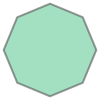

In [6]:
from shapely.geometry import Polygon
from shapely.wkt import loads
buff = loads(data[0][0])
buff

# quad_segs = 1 : 회전된 정사각형, 2 : 8각형

## 거리와 주변

### 1. 두 점 사이의 거리

- ::geography는 geometry를 geography로 캐스팅
1. location의 id가 1, 2인 두 포인트 a, b 사이의 거리
2. location의 id가 1인 포인트 a와 하드코딩 된 포인트 사이의 거리

In [17]:
cursor.execute("SELECT ST_Distance(a.location::geography,b.location::geography) FROM points a, points b where a.id =1 AND b.id = 2")
dist=cursor.fetchall()
dist

[(1109415.63241013,)]

In [23]:
cursor.execute("SELECT ST_Distance(a.location::geography,ST_GeometryFromText('POINT(100 30)')::geography) FROM points a where a.id = 1")
cursor.fetchall()

#from shapely.geometry import Point
#p=Point(100, 30)
#cursor.execute("SELECT ST_Distance(a.location::geography, ST_GeometryFromText('{}')::geography) FROM points a where a.id = 1".format(p.wkt))
#cursor.fetchall()

[(1109415.63241013,)]

### 2. 지정된 점으로부터 5개의 포인트와의 거리

In [5]:
cursor.execute("SELECT id, ST_Distance(location::geography, ST_GeometryFromText('POINT(140 30)')::geography) as d from points LIMIT 5")
cursor.fetchall()

[(1, 3781143.38471698),
 (2, 3839145.44034026),
 (3, 4164208.30846167),
 (4, 2416139.88255464),
 (5, 554479.50375456)]

### 3. KNN을 이용한 지정한 점에 가장 가까운 5개 점

In [4]:
cursor.execute("SELECT id, ST_Distance(location::geography, ST_GeometryFromText('POINT(140 30)')::geography) as d from points ORDER BY location<->ST_GeometryFromText('POINT(140 30)') LIMIT 5")
cursor.fetchall()

[(5, 554479.50375456),
 (4, 2416139.88255464),
 (6, 3104263.72620867),
 (2, 3839145.44034026),
 (3, 4164208.30846167)]

## KNN을 이용한 지정한 점에 가장 가까운 3개 점 얻기

In [2]:
cursor.execute("SELECT name, ST_Distance(location::geography, ST_GeometryFromText('Point(-106.59, 35.15)')::geography) as d from points ORDER BY location<->ST_GeometryFromText('Point(-106.59, 35.15)') LIMIT 3")
cursor.fetchall() 

InternalError_: 오류:  parse error - invalid geometry
HINT:  "Point(-106.59, 3" <-- parse error at position 16 within geometry


## line 데이터 다루기

In [26]:
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

connection = psycopg2.connect(database="pythonspatial", user="dajomi", password="dajomi")
cursor=connection.cursor()

In [8]:
cursor.execute("CREATE TABLE lines(id SERIAL PRIMARY KEY, location GEOMETRY)")

In [9]:
thelines = []
thelines.append(LineString([(-106.635585,35.086972),(-106.621294,35.124997)]))
thelines.append(LineString([(-106.498309,35.140108),(-106.497010,35.069488)])) 
thelines.append(LineString([(-106.663878,35.106459),(-106.586506,35.103979)]))
mls=MultiLineString([((-106.635585,35.086972),(-106.621294,35.124997)),((-106.498309,35.140108),(-106.497010,35.069488)),((-106.663878 ,35.106459),(-106.586506,35.103979))])
for a in thelines:
    cursor.execute("INSERT INTO lines (location) VALUES (ST_GeometryFromText('{}'))".format(a.wkt))
connection.commit()

In [14]:
cursor.execute("SELECT id, ST_AsTexT(location) from lines") # ST_AsTexT(geometry column)은 데이터를 WKT로 반환
data = cursor.fetchall()
data

[(1, 'LINESTRING(-106.635585 35.086972,-106.621294 35.124997)'),
 (2, 'LINESTRING(-106.498309 35.140108,-106.49701 35.069488)'),
 (3, 'LINESTRING(-106.663878 35.106459,-106.586506 35.103979)')]

### 1. 선의 길이

In [15]:
cursor.execute("SELECT id, ST_Length(location::geography) FROM lines")
cursor.fetchall()

[(1, 4415.210268081089), (2, 7835.6540540819515), (3, 7059.458405023586)]

### 2. 길이 오름차순

In [16]:
cursor.execute("SELECT id, ST_Length(location::geography) FROM lines ORDER BY ST_Length(location::geography)")
cursor.fetchall()

[(1, 4415.210268081089), (3, 7059.458405023586), (2, 7835.6540540819515)]

### 3. 선 교차하기

In [27]:
cursor.execute("SELECT ST_Intersects(l.location::geography, ll.location::geography) FROM lines l, lines ll WHERE l.id = 1 AND ll.id = 3")
cursor.fetchall()

[(True,)]

### 4. 교차하는 점

In [28]:
cursor.execute("SELECT ST_AsTexT(ST_Intersection(l.location::geography, ll.location::geography)) FROM lines l, lines ll WHERE l.id = 1 AND ll.id = 3")
cursor.fetchall()

[('POINT(-106.62868446550843 35.10533709574849)',)]

## polygon 데이터 다루기

In [37]:
from shapely.geometry import Polygon
connection = psycopg2.connect(database="pythonspatial",user="dajomi",password="dajomi")
cursor = connection.cursor()

In [23]:
cursor.execute("CREATE TABLE poly (id SERIAL PRIMARY KEY, location GEOMETRY)")
a = Polygon([(-106.936763,35.958191),(-106.944385,35.239293),(-106.452396,35.281908),(-106.407844,35.948708)]) 
cursor.execute("INSERT INTO poly (location) VALUES (ST_GeomFromText('{}'))".format(a.wkt))
connection.commit()

### 1. polygon Area

In [25]:
cursor.execute("SELECT id, ST_Area(location::geography) FROM poly")
cursor.fetchall()

[(1, 3550790242.521051)]

### 2. polygon 내부의 포인트(ST_Contains(polygon, point)) <-> ST_Within

In [38]:
from shapely.geometry import Point
isin = Point(-106.558743, 35.318618)
cursor.execute("SELECT ST_Contains(polygon.location, ST_GeomFromText('{}')) FROM poly polygon WHERE polygon.id = 1".format(isin.wkt))
cursor.fetchall()

[(True,)]

### 3. polygon 내부 or 겹치는 포인트(ST_Interesect(point,polygon))

In [39]:
isin=Point(-106.558743, 35.318618)
cursor.execute("SELECT ST_Intersects(ST_GeomFromText('{}')::geography, polygon.location::geometry) FROM poly polygon WHERE polygon.id = 1".format(isin.wkt))
cursor.fetchall()

[(True,)]

### 4. polygon과 교차하는 linestring

In [41]:
isin = LineString([(-106.55, 35.31), (-106.40, 35.94)])
cursor.execute("SELECT ST_AsTexT(ST_Intersection(polygon.location, ST_GeomFromText('{}'))) FROM poly polygon WHERE polygon.id = 1".format(isin.wkt))
cursor.fetchall()

[('LINESTRING(-106.55 35.31,-106.41171264025137 35.890806910944306)',)]